In [1]:
import os
import json
import seaborn as sns
import baltic as bt
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import pickle
colors = pickle.load(open('../../figures/colors.p', 'rb'))

In [3]:
lam_vals = range(0,21) + [30,50]

# for l in lam_vals:
    
#     path = '../../lasso/lam_drop_%d/'%l
#     mkdir_cmd = 'mkdir '+path
#     process_cmd = 'python dengue.process.py --lam_drop %d --output %s --no_tree_freqs'%(l, path)
    
#     print mkdir_cmd
#     print process_cmd
#     print '\n\n'

In [4]:
tree = bt.loadJSON('../shared_output/dengue_all_tree.json', json_translation={'height': 'div', 'name': 'strain'})


Tree height: 0.463664
Tree length: 9.978979
annotations present

Numbers of objects in tree: 4716 (2149 nodes and 2567 leaves)



In [8]:
def get_rmse(perf_path):
    rmse = pd.read_csv(perf_path, index_col=None)['rms_error']
    return rmse

rmse = {}
dTiters = {}
for d in lam_vals:
    if d in rmse or d < 1:
        continue
    rmse[d] = get_rmse('./lam_drop_%d/titer_model_performance.csv'%d)
    dTiter_path = './lam_drop_%d/tree_model.json'%d
    dTiters[d] = json.load(open(dTiter_path, 'r'))['dTiter']

In [9]:
def is_interserotype(node):
    if node.branchType == 'leaf':
        return False
    descendents = node.leaves
    serotypes = [k.split('/')[0] for k in descendents]
    serotypes = [s for s in serotypes if s != 'DENV']
    return len(set(serotypes)) > 1

interserotype_branches = []
for k in tree.Objects:
    if is_interserotype(k):
        interserotype_branches.append(k)
        interserotype_branches += k.children
interserotype_branches = [ k.traits['clade'] for k in interserotype_branches]

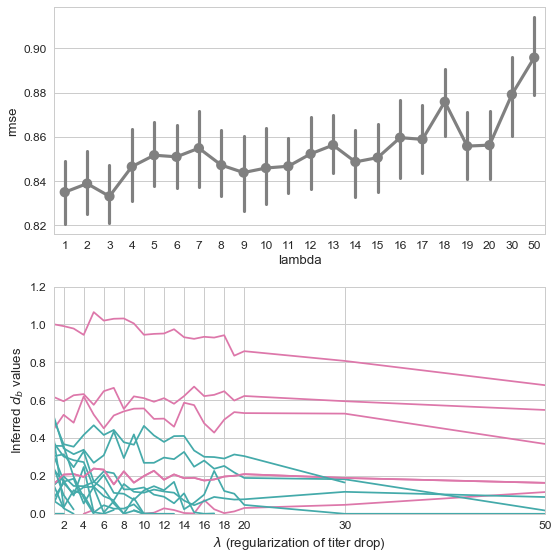

In [10]:
sns.set(style='whitegrid', font_scale=1.2)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,8))

rmse_ax = axes[0]
rmse_vals = pd.DataFrame.from_dict(rmse, orient="columns").melt(var_name='lambda', value_name='rmse')
rmse_vals.head()
sns.pointplot(x='lambda', y='rmse', data=rmse_vals, color='gray', ax=rmse_ax,dodge=True)

# rmse_x = sorted(rmse.keys())
# rmse_y = [rmse[x] for x in rmse_x]
# rmse_ax.plot(rmse_x,rmse_y,'-o', c='gray')
# rmse_ax.set_ylabel('Root mean squared error')
# rmse_ax.set_xticks(lam_vals[::2]+[30])

db_ax = axes[1]
db_vals = pd.DataFrame(dTiters)
for clade, d_b in db_vals.iterrows():
    if int(clade) in interserotype_branches:
        c = colors['interserotype_effects']
    else:
        c = colors['all_effects']
    db_ax.plot(db_vals.columns.values, d_b, color=c)
db_ax.set_xticks(lam_vals[::2]+[30])
db_ax.set_ylabel(r'Inferred $d_b$ values')
db_ax.set_xlabel(r'$\lambda$ (regularization of titer drop)')
db_ax.set_ylim(0,1.2)

db_ax.set_xlim(1,50)
plt.tight_layout()
plt.show()

NameError: global name 'ax' is not defined

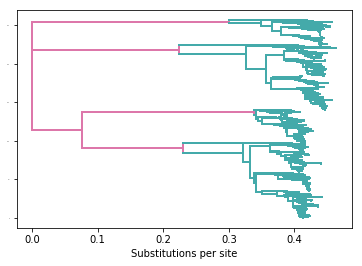

In [6]:
def plot_tree(tree):
    branchWidth=2 ## default branch width
    ll = tree

    plt.yticks(size=0)
    
    for k in ll.Objects: ## iterate over objects in tree
        x=k.x ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
            
        if 'clade' in k.traits:
            if int(k.traits['clade']) in interserotype_branches:
                c = colors['interserotype_effects']
            else:
                c = colors['all_effects']
        else:
            c = 'gray'

        z = 10
        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            pass
#             s=50 ## tip size can be fixed
#             s=50-30*k.height/ll.treeHeight
            
#             if colorby in k.traits:
#                 label = k.traits[colorby].replace('_', ' ')
#             else:
#                 label = ''
#             plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=z+1, label=label) ## plot circle for every tip
#             plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=z) ## plot black circle underneath
                        
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            plt.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=z-1)
            
        plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=z-1)
    plt.xlabel('Substitutions per site')
    
    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.grid(True)
#     ax.spines['bottom'].set_visible(False)

    x0,x1 = plt.xlim()
    plt.xlim((x0, x1))
    
plot_tree(tree)